# Generate ML tree figure with metadata 
Metadata comes from several locations thus we must merge tables (see below)

In [1]:
library(phangorn)
library(ape)
library(ggtree)
library(treeio)
library(ggplot2)
library(tibble)
library(dplyr)
library(castor)
library(ggnewscale)
library(RColorBrewer) # for brewer.pal()
library(ggpubr)
library(readxl)
library(ggtreeExtra)
library(tidyverse)

Loading required package: ape

ggtree v3.12.0 For help: https://yulab-smu.top/treedata-book/

If you use the ggtree package suite in published research, please cite
the appropriate paper(s):

Guangchuang Yu, David Smith, Huachen Zhu, Yi Guan, Tommy Tsan-Yuk Lam.
ggtree: an R package for visualization and annotation of phylogenetic
trees with their covariates and other associated data. Methods in
Ecology and Evolution. 2017, 8(1):28-36. doi:10.1111/2041-210X.12628

Guangchuang Yu. Using ggtree to visualize data on tree-like structures.
Current Protocols in Bioinformatics. 2020, 69:e96. doi:10.1002/cpbi.96

Guangchuang Yu.  Data Integration, Manipulation and Visualization of
Phylogenetic Trees (1st edition). Chapman and Hall/CRC. 2022,
doi:10.1201/9781003279242 


Attaching package: ‘ggtree’


The following object is masked from ‘package:ape’:

    rotate


treeio v1.28.0 For help: https://yulab-smu.top/treedata-book/

If you use the ggtree package suite in published research, please cit


housekeeping notes: 

* we used bakta on both the 19 MAGs and 60 genomes (out of 391 annotated w bakta)
* we use the metadata info to define sequence names
* `21EPA017CP03` was removed from plot 
* different laptops had different versions of libraries: working treeio (n114312 desktop) is v1.24.3 and ggtree v3.8.2 , ggtreeExtra v1.10.0 
* rename 21EPA011 to 20EPA011 and 21EPA027 to 20EPA027 (I modified `231020.` into `240104.MAGs_Tree...xlsx`) 

#### Load metadata and harmonise names s.t. tables can be joined

In [2]:
# read excel file with metadata (prepared for this figure) skipping the first row
meta0 <- read_excel("00.metadata_for_figure_7.xlsx", sheet = "MAG_Tree_metadata", skip = 1)
metadata <- meta0
dim(metadata) ## check dimensions 

## the proper way to do the below would be check (and exclude) matches, retaining only unmatched for next step
## fix metadata discrepancies: EPA085CP05 misses EPA085CP5
meta0$ID_on_Tree <- sub("0([1-9])$", "\\1", meta0$ID_on_Tree) # create more elements without the last zero
metadata <-  rbind(metadata, meta0)
metadata <- metadata[!duplicated(metadata),] # remove duplicates

# EPA85CP05 also misses EPA085CP05 thus we create EPA0 from all EPA
meta0 <- metadata
meta0$ID_on_Tree <- sub("EPA", "EPA0", meta0$ID_on_Tree) # create more elements with an extra zero
metadata <-  rbind(metadata, meta0)
metadata <- metadata[!duplicated(metadata),] # remove duplicates

# OTOH EPA077CP09 misses EPA077CP9
meta0 <- metadata
# replace last digit, if present, by zero + last digit
meta0$ID_on_Tree <- sub("([0-9])$", "0\\1", meta0$ID_on_Tree)
metadata <-  rbind(metadata, meta0)
metadata <- metadata[!duplicated(metadata),] # remove duplicates

dim(metadata) ## check dimensions again (after creating more elements)
## remove AMR info received since we reestimated it 
metadata <- metadata[,c("ID_on_Tree", "Sample_ID", "Genome_Source", "Species", "ST")]
colnames(metadata)[colnames(metadata) == "ST"] <- "ST_from_bilal" # make a distinction where mlst is final one
tail(metadata)
# optional : check augmented metadata
#write.table(metadata, "_test_all_combis.tsv", sep = "\t", quote = FALSE, row.names = FALSE)

[1] 83 20

[1] 410  20

ID_on_Tree,Sample_ID,Genome_Source,Species,ST_from_bilal
<chr>,<chr>,<chr>,<chr>,<chr>
m_EPA0803,22EPA083CP,MAG,C. jejuni,6532
m_EPA0805,22EPA085CP,MAG,C. Jejuni,-
m_EPA0807,22EPA087CP,MAG,C. coli,1055
m_EPA0808,22EPA088CP,MAG,C. Jejuni,883
m_EPA0904,22EPA094CP,MAG,C. Jejuni,-
m_EPA0907,22EPA097CP,MAG,C. Jejuni,6175


In [4]:
mlst <- read.table("01.mlst_mags.tsv", header=F)
mlst <- rbind (mlst, read.table("01.mlst_genomes.tsv", header=F))
mlst$V1 <- gsub (".fasta.gz","", mlst$V1)
mlst$V1 <- gsub (".fasta","", mlst$V1) # genomes have no .gz
# remove both - and _ from the names
mlst$V1 <- gsub ("[-_.]","", mlst$V1)
mlst <- mlst[,c("V1","V3")]
colnames(mlst) <- c("key","mlst")

amr <- read.table("02.amrfinder.wide.tsv", header=T, check.names=F)
amr$key <- gsub ("[-_.]","", amr$sample)
amr <- subset (amr, select=-sample)
amr <- amr[, c('key', setdiff(names(amr), 'key'))] # rearrange order s.t. "key" comes first
amr_names <- setdiff(names(amr), c('key', 'mlst', 'mag'))

mlst <- merge(mlst, amr, by="key", all.x=T, all.y=T)
# replace NA by "NO" on amr genes, since some samples (EPA11 mag) do not have any amr genes
mlst <- mlst %>% mutate_at (vars(amr_names), ~ifelse(is.na(.), "NO", .)) # replace NA by 0
head(mlst)

Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(amr_names)

  # Now:
  data %>% select(all_of(amr_names))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”


,key,mlst,mag,50S_L22_A103V,aac(3)-IId,aadE,acr3,arsC,arsD,arsP,⋯,iucA,iucB,iucC,iutA,merC,merP,merR,merT,satA,tet(O)
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,20EPA017CPAK9178AK390953937metawrap7010binsbin9,5136,yes,YES,NO,NO,YES,NO,NO,NO,⋯,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO
2,20EPA11CFNOVASEQ48413metawrap7010binsbin1,61,NA,NO,NO,NO,NO,NO,NO,NO,⋯,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO
3,20EPA27CPNOVASEQ48412metawrap7010binsbin6,827,yes,YES,NO,NO,YES,NO,NO,NO,⋯,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO
4,21EPA034CFAK9164AK916553941metawrap7010binsbin16,9897,yes,NO,NO,NO,NO,NO,NO,NO,⋯,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO
5,21EPA039CFAK9320AK754453942metawrap7010binsbin5,45,yes,NO,NO,NO,YES,NO,NO,NO,⋯,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO
6,22EPA078CP69056metawrap7010binsbin18,137,yes,NO,NO,NO,NO,NO,NO,NO,⋯,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO


In [6]:
sptable <- read.table("03.GTDBTk.isolates.names_species.tsv", header=F, skip=1, sep="\t",col.names=c("taxon","species")) 
spt2 <- read.table("03.GTDBTk.mags.names_species.tsv", header=T, sep="\t")
sptable <- rbind(sptable, spt2) ## this has metawrap concoct etc. and _original_ names
spt2 <- read.table("03.GTDBTk.mags_new.names_species.tsv", header=T, sep="\t") ## new metagenomes from 8th Sept
sptable <- rbind(sptable, spt2) ## this has metawrap concoct etc. and _original_ names

sptable$key <- gsub ("[-_.]","", sptable$taxon)
sptable <- merge (sptable, mlst, by="key", all.x=T)
sptable$key <- NULL  # delete column key
head (sptable)

df_from_table <- function (species_table) { # "S21EPA049CF__58394_metawrap_70_10_bins_bin_5" and "PID_0836_21EPA049CF6__57784"
    tip <- gsub("\'", "", species_table$taxon)
    # remove everything after two uderscores from tip labels
    #tip<- gsub("PID.{1}\\d+.{1}\\d+EPA", "EPA",  gsub("__\\d+", "", tip)) ## Fixes single seq genomes
    tip <- gsub ("PID.+EPA", "EPA",  gsub("__\\d+", "", tip)) ## Fixes single seq genomes
    tip <- gsub ("-", "_", tip) ## EPA097-1 is EPA097_1 for bakta (and 097 is the only with hifen in name)
    #t1$tip.label <- gsub("\\d+EPA\\d+CF__\\d+", "", t1$tip.label) ## Fixes MAGs 
    idx2 <- grep("concoct", tip); idx3 <- grep("maxbin", tip);
    idx_remove <- unique(c(idx2, idx3)) # should be unique anyway
    tip <- tip[-idx_remove];

    species_table <- species_table[-idx_remove,]
    species_table <- species_table %>% rename(original_names=taxon, tbl_species=species)

    idx <- grep("metawrap", tip); tip[idx] <- gsub(".*(EPA.{3}).*", "\\1", tip[idx])

    species_table$tbl_mag <- rep("no",length(tip)); 
    species_table$tbl_mag[idx] <- "yes"
    species_table$tbl_sample <- as.character(  as.integer(gsub(".*EPA(\\d+).*", "\\1", tip)) ) # 83 17 39 27 97 15 49 88 41 11 79 34 78 87 50 80 85 77
    tip[idx] <- paste ("m_EPA", species_table$tbl_sample[idx], sep="") ## new name is m_EPA83 etc.
    species_table$label <- tip
    cat ("vector with length ", length(tip), " and ", length(idx), " MAGs \n")
    cat ("metagenomic samples: ", tip[idx], "\n")
    return (species_table)
    #data.frame(tbl_mag=is_mag, label=tip, tbl_sample=sample, tbl_species=species, mlst=mlst, original_names=original_names) ## rownames(df) <- t1$tip.label not needed for tibble
}

df0 <- df_from_table (sptable)
write.csv(df0, "output.species_table_wtih_newnames.csv", row.names=F, quote=F)
head (df0)

,taxon,species,mlst,mag,50S_L22_A103V,aac(3)-IId,aadE,acr3,arsC,arsD,⋯,iucA,iucB,iucC,iutA,merC,merP,merR,merT,satA,tet(O)
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,20EPA017CP_AK9178_AK3909__53937_concoct_bins_bin.93,s__Campylobacter_D jejuni,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,20EPA017CP_AK9178_AK3909__53937_maxbin2_bins_bin.43,s__Campylobacter_D jejuni,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,20EPA017CP_AK9178_AK3909__53937_metawrap_70_10_bins_bin.9,s__Campylobacter_D jejuni,5136,yes,YES,NO,NO,YES,NO,NO,⋯,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO
4,20EPA11CF_NOVASEQ__48413_concoct_bins_bin.79,s__Campylobacter_D jejuni,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,20EPA11CF_NOVASEQ__48413_maxbin2_bins_bin.4,s__Campylobacter_D jejuni,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,20EPA11CF_NOVASEQ__48413_metawrap_70_10_bins_bin.1,s__Campylobacter_D jejuni,61,NA,NO,NO,NO,NO,NO,NO,⋯,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO


vector with length  410  and  19  MAGs 
metagenomic samples:  m_EPA17 m_EPA11 m_EPA27 m_EPA34 m_EPA39 m_EPA78 m_EPA77 m_EPA79 m_EPA80 m_EPA83 m_EPA70 m_EPA85 m_EPA87 m_EPA88 m_EPA94 m_EPA97 m_EPA41 m_EPA49 m_EPA55 


,original_names,tbl_species,mlst,mag,50S_L22_A103V,aac(3)-IId,aadE,acr3,arsC,arsD,⋯,iutA,merC,merP,merR,merT,satA,tet(O),tbl_mag,tbl_sample,label
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
3,20EPA017CP_AK9178_AK3909__53937_metawrap_70_10_bins_bin.9,s__Campylobacter_D jejuni,5136,yes,YES,NO,NO,YES,NO,NO,⋯,NO,NO,NO,NO,NO,NO,NO,yes,17,m_EPA17
6,20EPA11CF_NOVASEQ__48413_metawrap_70_10_bins_bin.1,s__Campylobacter_D jejuni,61,NA,NO,NO,NO,NO,NO,NO,⋯,NO,NO,NO,NO,NO,NO,NO,yes,11,m_EPA11
11,20EPA27CP_NOVASEQ__48412_metawrap_70_10_bins_bin.6,s__Campylobacter_D coli,827,yes,YES,NO,NO,YES,NO,NO,⋯,NO,NO,NO,NO,NO,NO,NO,yes,27,m_EPA27
14,21EPA034CF_AK9164_AK9165__53941_metawrap_70_10_bins_bin.16,s__Campylobacter_D jejuni,9897,yes,NO,NO,NO,NO,NO,NO,⋯,NO,NO,NO,NO,NO,NO,NO,yes,34,m_EPA34
17,21EPA039CF_AK9320_AK7544__53942_metawrap_70_10_bins_bin.5,s__Campylobacter_D jejuni,45,yes,NO,NO,NO,YES,NO,NO,⋯,NO,NO,NO,NO,NO,NO,NO,yes,39,m_EPA39
20,22EPA078CP__69056_metawrap_70_10_bins_bin.18,s__Campylobacter_D jejuni,137,yes,NO,NO,NO,NO,NO,NO,⋯,NO,NO,NO,NO,NO,NO,NO,yes,78,m_EPA78


In [8]:
# merge df with info from metadata where label == ID_on_tree
df <- merge(df0, metadata, by.x="label", by.y="ID_on_Tree", all.x=T) ## all.x is needed if metadata is incomplete
# if info is missing from Bilal's, then use from original (Leo's) info
df$ID_on_Tree[is.na(df$ID_on_Tree)] <- df$label[is.na(df$ID_on_Tree)]
df$Sample_ID[is.na(df$Sample_ID)]   <- df$label[is.na(df$Sample_ID)]
df$Species[is.na(df$Species)]       <- df$tbl_species[is.na(df$Species)]
df$Genome_Source[is.na(df$Genome_Source)] <- ifelse(df[is.na(df$Genome_Source),]$tbl_mag=="yes", "MAG", "Isolate")
df$mlst[is.na(df$mlst)] <- "-" 

# Fix some other typoes
## if there is "coli" anywhere in Species, then it is C. coli; otherwise is C. jejuni
df$Species <- ifelse(grepl("coli", df$Species), "C. coli", "C. jejuni")
df$Sample_ID <- gsub ("21EPA017CP03", "20EPA017CP03", df$Sample_ID) # typo

df <- df[apply(df, 1, function(x) any(!is.na(x))), ] ## remove rows with NA only (not needed)
print(dim(df[duplicated(df$ID_on_Tree),])) ## check for duplicates
print(dim(df[duplicated(df$tbl_label),])) ## check for duplicates
print(dim(df[duplicated(df$Sample_ID),])) ## has many duplicates == NA
print ("the 3 above should be 0")
write.csv(df, "output.species_table_wtih_newnames.csv", row.names=F, quote=F)

[1]  0 44
[1]  0 44
[1]  0 44
[1] "the 3 above should be 0"
[1]  0 44
[1]  0 44
[1] "the 3 above should be 0"


In [9]:
# counts of every Genome_Source and tbl_MAG combination on df
df %>% group_by(Genome_Source, tbl_mag) %>% summarise(count=n()) %>% arrange(Genome_Source, tbl_mag)

`summarise()` has grouped output by 'Genome_Source'. You can override using the
`.groups` argument.


Genome_Source,tbl_mag,count
<chr>,<chr>,<int>
Isolate,no,391
MAG,yes,19


In [11]:
table_replace <- read.csv ("04.name_mapping.csv", header=TRUE)
table_replace$shortname <- paste ("m_", table_replace$shortname, sep="")
head (table_replace)

# Internally consistent names, not display names 
replace_panaroo_names <- function (oldnames) {
    tip <- gsub ("PID.+EPA", "EPA",  gsub("__\\d+_gff", "", oldnames))
    tip <- gsub ("PID.+EPA", "EPA",  gsub("__\\d+", "", oldnames))
    idx <- grep("metawrap", tip) #; tip[idx] <- gsub(".*(EPA.{3}).*", "m_\\1", tip[idx])
    sample <- as.character(  as.integer(gsub(".*EPA(\\d+).*", "\\1", tip)) ) # 83 17 39 27 97 15 49 88 41 11 79 34 78 87 50 80 85 77
    tip[idx] <- paste ("m_EPA", sample[idx], sep="") ## new name is m_EPA83 etc.
    cat ("labels not in tbl <BEGIN> ", tip[! tip %in% df$label], " <END>\n")
    cat ("tbl not in labels (not relevant for tree plotting)\n<BEGIN> ", df$label[! df$label %in% tip], " <END>\n")
    return (tip)
}

,seqname,roary_name,shortname
,<chr>,<chr>,<chr>
1,20EPA11CF_NOVASEQ__48413_metawrap_70_10_bins_bin.1,Prokka_on_data_1__gff,m_EPA11
2,20EPA017CP_AK9178_AK3909__53937_metawrap_70_10_bins_bin.9,Prokka_on_data_2__gff,m_EPA17
3,20EPA27CP_NOVASEQ__48412_metawrap_70_10_bins_bin.6,Prokka_on_data_3__gff,m_EPA27
4,21EPA034CF_AK9164_AK9165__53941_metawrap_70_10_bins_bin.16,Prokka_on_data_4__gff,m_EPA34
5,21EPA039CF_AK9320_AK7544__53942_metawrap_70_10_bins_bin.5,Prokka_on_data_5__gff,m_EPA39
6,22EPA078CP__69056_metawrap_70_10_bins_bin.18,Prokka_on_data_6__gff,m_EPA78


In [12]:
ancestral_tree_states <- function (tre0, mk, states) {
    x2 <- map_to_state_space (states);
    
    if (class(tre0)!= "phylo") {tre <- tre0@phylo; } ## may be treedata
    else { tre <- tre0;}
    if (mk == TRUE){ mk <- asr_mk_model (tre, x2$mapped_states, rate_model="SYM"); }
    else           { mk <- asr_max_parsimony (tre, x2$mapped_states, weight_by_scenarios=FALSE); }
    x3 <- apply(mk$ancestral_likelihoods, 1, which.max);
    return (c(states, x2$state_names[x3]));
}

tree_with_ancestral_df <- function (tre, mk=FALSE, df0, reroot=FALSE) {
    # create rows for all tips in the tree not in df0$label (SHOULD NOT HAPPEN)
    #new_labels <- tre$tip.label[! tre$tip.label %in% df0$label]
    #df <- data.frame(matrix(ncol=ncol(df0), nrow=length(new_labels)))
    #names(df) <- names(df0)
    #df$label <- new_labels; # df$Sample_ID <- df$label; df$Species <- "C. jejuni"; df$ST <- ""; df$tbl_sample <- ""
    #df <- rbind(df0, df)

    tre$tip.label <- replace_panaroo_names (tre$tip.label)
    cat ("first tip labels of ML tree: ",tre$tip.label[1:10], "\n")

    df <- df0
    
    tre$tip.label <- df$Sample_ID[match(tre$tip.label, df$label)] # replace tip labels with Sample_ID
    print ("checking for duplicates")
    print (df$label[duplicated(df$Sample_ID)]) ## check for duplicates

    if (is.numeric(reroot)) {
        colinames <- df$Sample_ID[grep ("coli", df$Species)] # species from Bilal metadata, not from binning estimation by Leo
        colinames <- tre$tip.label[tre$tip.label %in% colinames]
        # mrca is a node, but we want the edge left to it
        mrca_edge = which(tre$edge[,2]==getMRCA(tre, colinames))[1] # first element in case of multifurcation (vector leads to infinite loop)
        tre <- castor::root_in_edge (tre, root_edge=mrca_edge, location=reroot) # location will give a root at halfway 
        cat ("rerooting at root of C. coli, and the MRCA is edge ", mrca_edge, "\n")
    }
    else if (reroot == TRUE) { tre <- midpoint (tre) }
    else { cat ("no reroot\n") } 
    df <- df %>% slice(match(tre$tip.label, Sample_ID))
    rownames(df) <- df$Sample_ID;
    ## ASR using castor and Bilal's metadata columns
    x1 <- ggtree(tre)$data[c("node","label")] 
    x1$mag <- ancestral_tree_states (tre, mk, df$Genome_Source) 
    x1$species <- ancestral_tree_states (tre, mk, df$Species)
    x1$sample <- ancestral_tree_states (tre, mk, df$tbl_sample)
    x1$ST <- ancestral_tree_states (tre, mk, df$mlst) ## used to be Bilal's ST, but now it's mlst from scratch using metawrap bins
    x1 <- full_join(ggtree(tre)$data, tibble(x1), by=c("node","label"))
    return (list(tree=as.treedata(x1), df=df))## as.treedata is important, from tidytree library; x1 is a tibble (called tbl_tree)
}

In [13]:
t1 <- read.tree ("05.trimal99.aln.treefile")
mags_without_isolates <- c("S21EPA055CF__58402_metawrap_70_10_bins_bin_7", #55, 70, and 94 don't have isolates
    "EPA70CPm_EKDL220009460_1A_HYV73DSX3__69053_metawrap_70_10_bins_bin_1",
    "PID_1316_22EPA094CP__84131_metawrap_70_10_bins_bin_7",
    "PID_0906_20EPA017CP3__59990") ## EPA017CP3 should be ST5136 but it's ST48 so there was some lab issue
t1 <- drop.tip (t1, mags_without_isolates)
t99 <- tree_with_ancestral_df (t1, df0=df, reroot=0.1)
# from email 2023.12.06 (overwrites email from 2023.11.17)
#t99$tre@phylo$tip.label <- gsub ("21EPA017CP03", "ST5136", t99$tre@phylo$tip.label)

write.tree (as.phylo(t99$tre), "output.trimal99.treefile")
t1

labels not in tbl <BEGIN>    <END>
tbl not in labels (not relevant for tree plotting)
<BEGIN>  EPA011CF1 EPA011CF10 EPA011CF11 EPA011CF12 EPA011CF13 EPA011CF2 EPA011CF5 EPA011CF6 EPA011CF8 EPA011CF9 EPA011CP1 EPA011CP10 EPA011CP11 EPA011CP12 EPA011CP13 EPA011CP14 EPA011CP15 EPA011CP2 EPA011CP3 EPA011CP4 EPA011CP5 EPA011CP6 EPA011CP7 EPA011CP8 EPA011CP9 EPA015CF10 EPA015CF11 EPA015CF12 EPA015CF13 EPA015CF14 EPA015CF2 EPA015CF3 EPA015CF4 EPA015CF5 EPA015CF6 EPA015CF7 EPA015CF8 EPA015CF9 EPA015CP1 EPA015CP10 EPA015CP11 EPA015CP12 EPA015CP13 EPA015CP14 EPA015CP15 EPA015CP2 EPA015CP4 EPA015CP5 EPA015CP6 EPA015CP7 EPA015CP9 EPA017CF12 EPA017CF13 EPA017CF15 EPA017CP15 EPA017CP2 EPA017CP3 EPA017CP4 EPA027CF1 EPA027CF10 EPA027CF11 EPA027CF12 EPA027CF13 EPA027CF14 EPA027CF2 EPA027CF4 EPA027CF5 EPA027CF6 EPA027CF7 EPA027CF9 EPA027CP1 EPA027CP10 EPA027CP11 EPA027CP12 EPA027CP13 EPA027CP14 EPA027CP15 EPA027CP2 EPA027CP3 EPA027CP4 EPA027CP5 EPA027CP6 EPA027CP7 EPA027CP8 EPA027CP9 EPA034CF1 EPA034CF1

Warning message in map_to_state_space(states):
“NAs introduced by coercion”
Warning message in map_to_state_space(states):
“NAs introduced by coercion”
Warning message in map_to_state_space(states):
“NAs introduced by coercion”



Phylogenetic tree with 75 tips and 74 internal nodes.

Tip labels:
  PID_0666_21EPA039CF14__52158, PID_0666_21EPA039CF11__52180, PID_0666_21EPA039CP6__52177, PID_0666_21EPA039CP1__52154, PID_0666_21EPA039CF8__52143, PID_0666_21EPA039CF13__52149, ...

Rooted; includes branch lengths.

Warning message in sort(as.numeric(as.character(unique(t99$df$ST)))):
“NAs introduced by coercion”
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


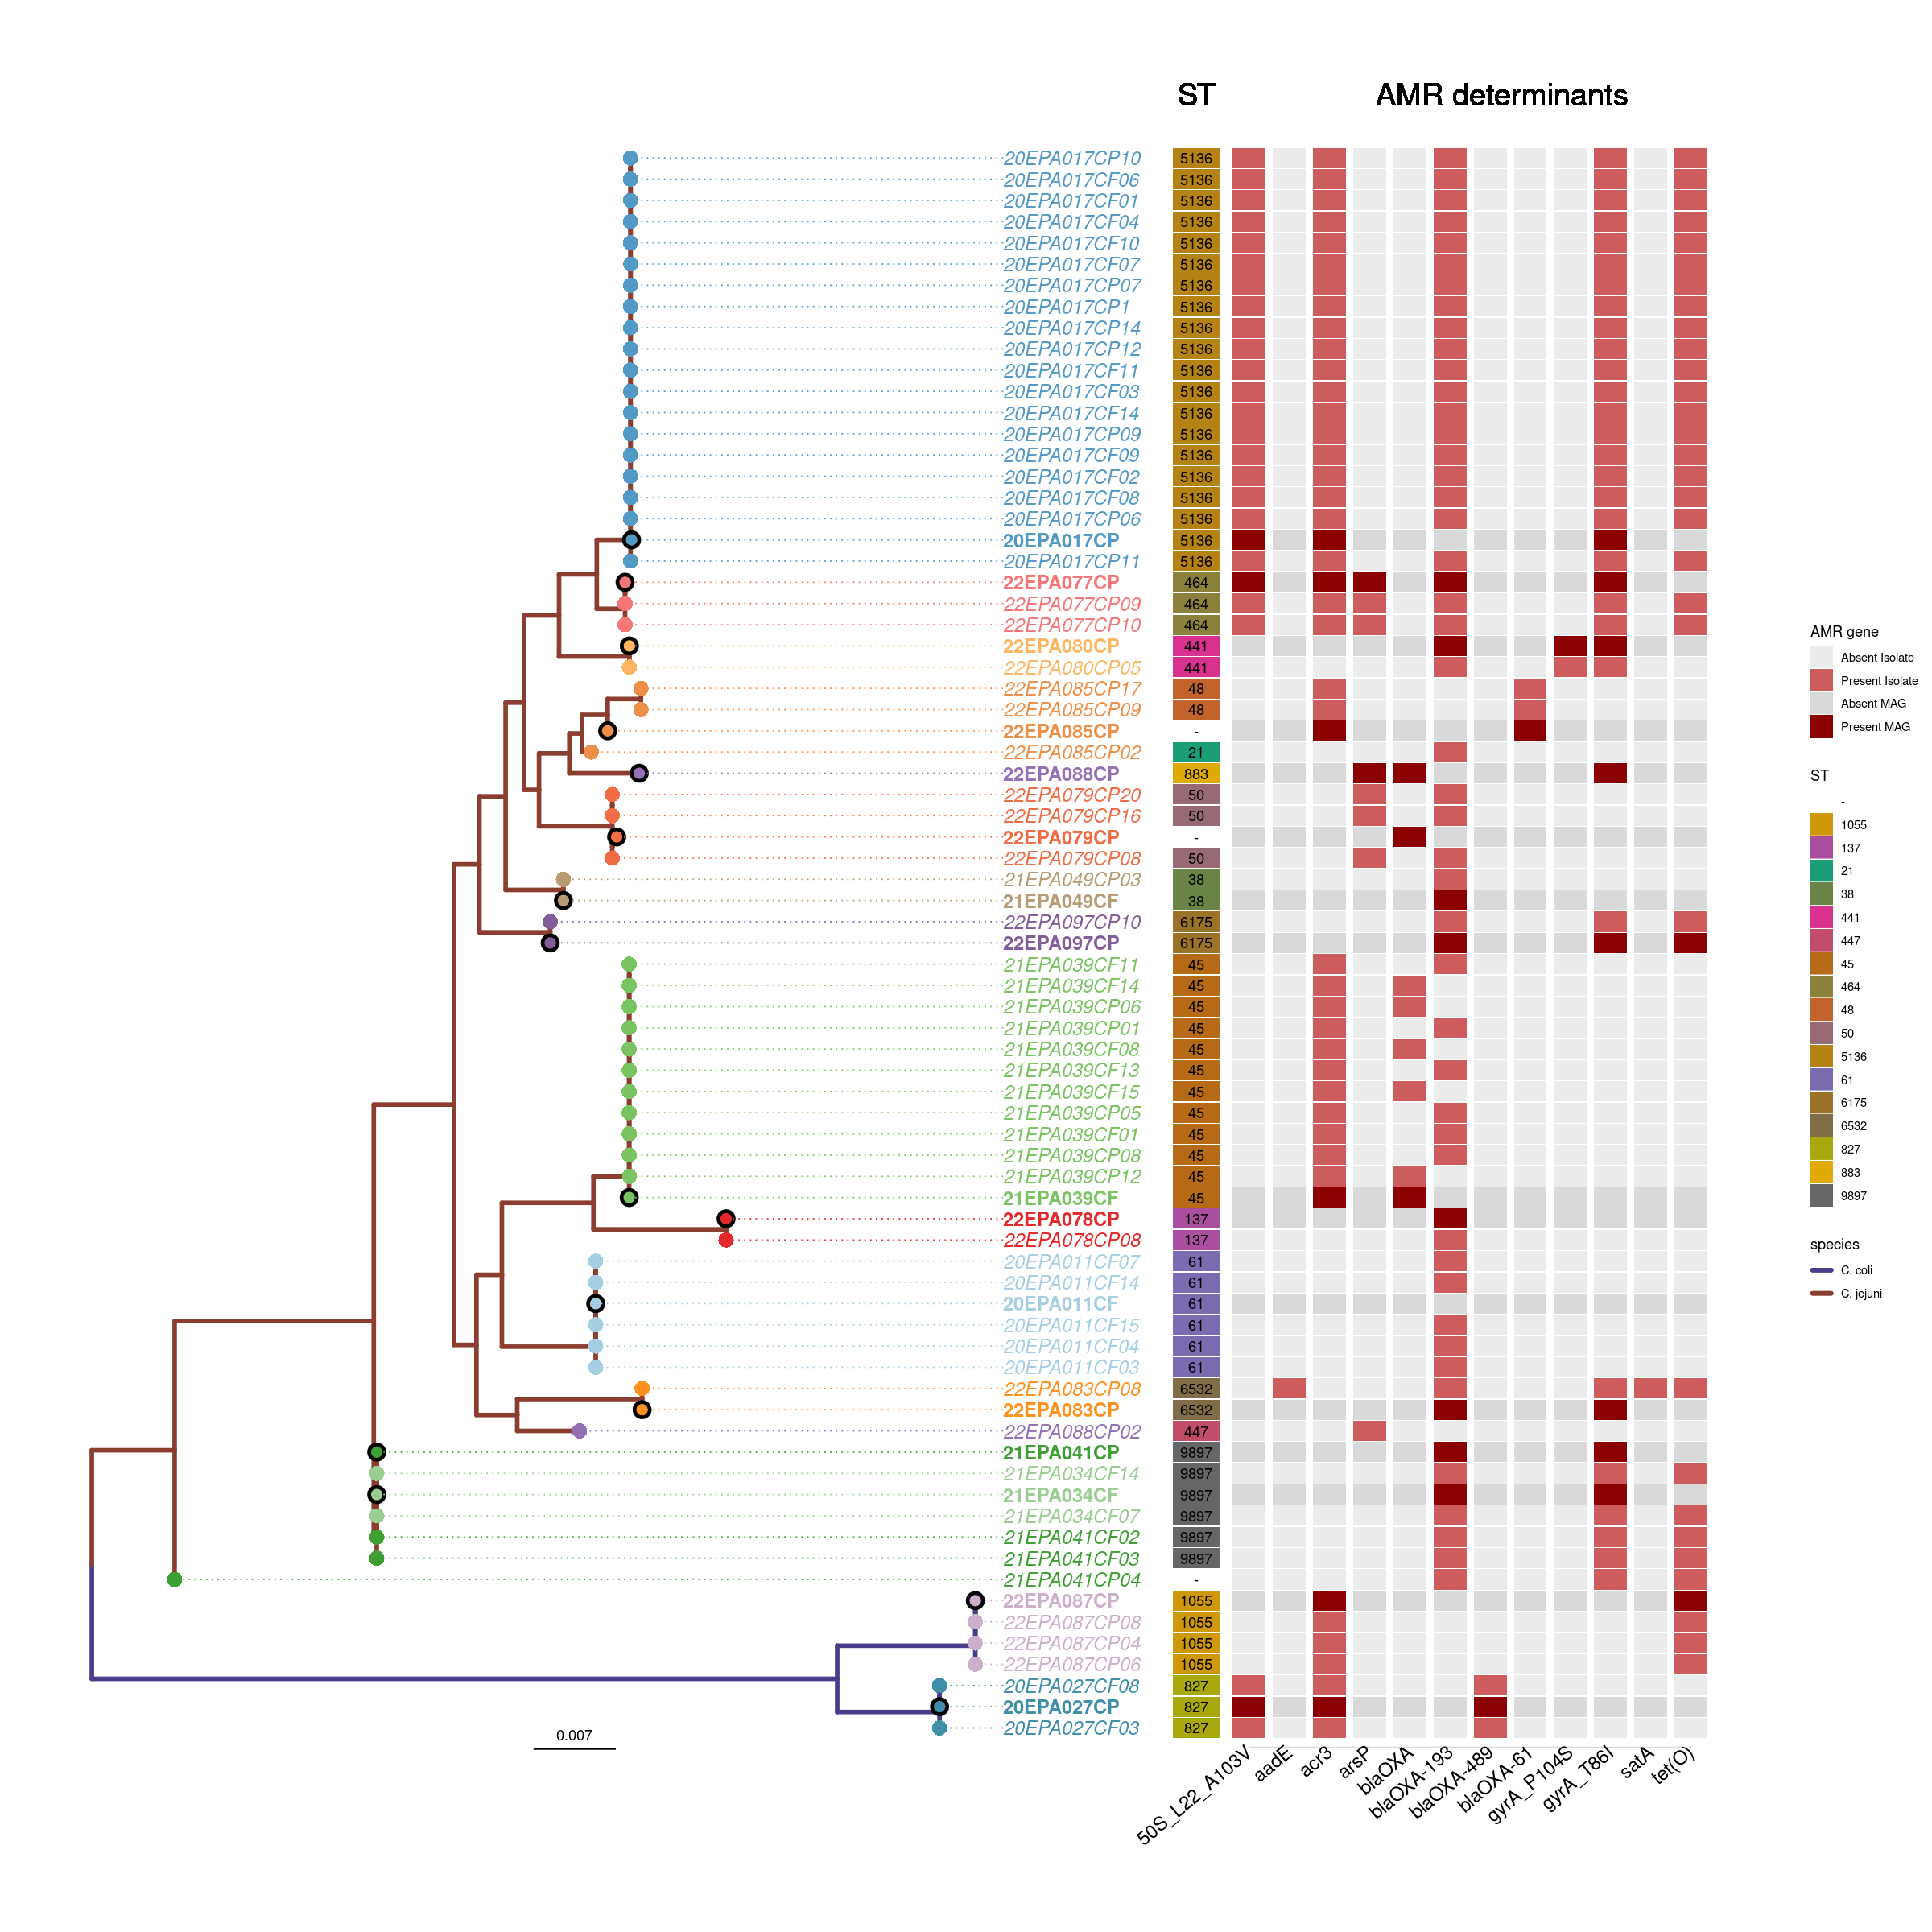

In [15]:
fac <-  sort(as.numeric(as.character(unique(t99$df$ST))))
getPal_ST = colorRampPalette( brewer.pal(8,"Dark2") )(length(fac))
names(getPal_ST) <- fac
getPal_ST["-"] <- "white"
mypal <- colorRampPalette(brewer.pal(12,"Paired"))(19)

# plot the tree t99$tree with the metadata from data frame t99$df
options (repr.plot.width=20, repr.plot.height=20)
p <- ggtree (t99$tree, aes(color=species),size=1.6) + scale_color_manual (values=c("darkslateblue", "coral4"))
p <- p + new_scale_color() + new_scale_fill()
p <- p + geom_tippoint (aes (colour=mag, fill=sample), pch=21, size=4, stroke=2)
p <- p + scale_colour_manual (values=c(alpha("white",alpha=0), "black"), guide="none") 
p <- p + scale_fill_manual (values=mypal, guide="none")
p <- p + new_scale("colour") + new_scale ("fill")

# select only columns fom df that match names in amr_names
df_tmp <- t99$df %>% select (all_of(amr_names))
df_tmp$Sample_ID <- rownames(df_tmp) 

df_tmp <- df_tmp[,colSums(df_tmp != "NO") > 0] # remove columns with only NO
# four options are: noYES, noNO, yesYES, yesNO (no, yes = mag and NO YES = amr gene)
amr_names_smaller <- setdiff(names(df_tmp), "Sample_ID") # create yesNO for combo mag+amr (setdiff=all columns minus Sample_ID)
df_tmp <- df_tmp %>% mutate_at (vars(amr_names_smaller), ~paste(t99$df$mag,., sep=""))
df_tmp <- df_tmp %>% pivot_longer (cols = -Sample_ID, names_to = "amr", values_to = "yesno")
# ST comes from treedata, not df
p <- p + geom_fruit(geom=geom_tile, mapping=aes(y=Sample_ID, fill=ST), offset=0.25, width=0.004, height=0.95,)
p <- p + geom_fruit(geom=geom_text, mapping=aes(y=Sample_ID, label=ST), offset=0.)
p <- p + ggplot2::scale_fill_manual(values = getPal_ST, na.value="white", name="ST")
p <- p + new_scale("colour") + new_scale ("fill")

p <- p + geom_fruit(
        geom=geom_tile, data=df_tmp, mapping=aes(y=Sample_ID, x=amr, fill=yesno), 
        pwidth=0.5, offset=0.03, width=0.0028, height = 0.95, # widht height are for each square
        axis.params=list(axis= "x", text.size  = 5, text.angle=40, hjust = 1, vjust= 0.5)
        )
p <- p + ggplot2::scale_fill_manual(values = c("noYES"="indianred","noNO"="gray92", "yesYES"="darkred","yesNO"="gray85"), 
        labels=c("yesYES"="Present MAG", "noYES"="Present Isolate", "yesNO"="Absent MAG", "noNO"="Absent Isolate"),
        na.value="gray85", name="AMR gene") ## na.value is quick-and-dirty since only one all-negative
p <- p + new_scale("colour") + new_scale ("fill")

bold_idx <- ifelse (t99$tree@data$mag=="MAG", "bold", "italic")

p <- p + geom_tiplab (size=5, aes(colour=sample, fontface=bold_idx), align=T, offset=0.002) 
p <- p + scale_colour_manual (values=mypal, guide="none")
p <- p + ylim (-4, 78) + geom_treescale() # + xlim(NA,0.1) 

p <- p + geom_text(aes(x=0.094, y=78, label="ST"), size=8, hjust=0.5)
p <- p + geom_text(aes(x=0.12, y=78, label="AMR determinants"), size=8, hjust=0.5)

p
ggsave ("output.trimal99.pdf", p, width=20, height=20)
ggsave ("output.trimal99.png", p, width=20, height=20)

## pangenome statistics
(there is a bed-like file from panaroo I believe so we could in theory calculate exact alignment length or alignment itself using core_gene alignment, but I'm not using it)
This only compares supermatrix length by using relaxed panaroo + trimal against strict panaroo, and shows how using trimal to select all **sites** with less than 1% indels is more strict than asking panaroo to select all **genes** missing in less than 1% of genomes.

In [16]:
a <- read.table("06.gene_presence_absence.Rtab", header=T)
## sum over columns for each row
a$sum <- rowSums(a[,2:ncol(a)])
dim(a)
genes_90 <- a$Gene[a$sum > 71]
genes_99 <- a$Gene[a$sum > 78]
length(genes_90)
length(genes_99)

a2 <- read.table("06.aligned_gene_sequences-length.tsv", header=F)
a_90 <- a2[a2$V1 %in% genes_90,]
a_99 <- a2[a2$V1 %in% genes_99,]
summary(a_90) ## alignments contain paralogs
summary(a_99) ## alignments contain paralogs

# trimal99 has 42224 bases, trimal90 has 515531 bases
cat ("at 99%: ", sum(a_99$V2), "(trimal gave 42224) and at 90%: ", sum(a_90$V2), " (trimal was at 515531) bases\n")


[1] 3844   81

[1] 739

[1] 87

      V1                  V2               V3        
 Length:739         Min.   :  99.0   Min.   : 72.00  
 Class :character   1st Qu.: 553.5   1st Qu.: 72.00  
 Mode  :character   Median : 843.0   Median : 72.00  
                    Mean   : 968.6   Mean   : 75.57  
                    3rd Qu.:1233.0   3rd Qu.: 77.00  
                    Max.   :4594.0   Max.   :192.00  

      V1                  V2               V3       
 Length:87          Min.   : 168.0   Min.   :79.00  
 Class :character   1st Qu.: 427.5   1st Qu.:79.00  
 Mode  :character   Median : 627.0   Median :79.00  
                    Mean   : 834.6   Mean   :79.07  
                    3rd Qu.:1104.0   3rd Qu.:79.00  
                    Max.   :4128.0   Max.   :82.00  

at 99%:  72612 (trimal gave 42224) and at 90%:  715770  (trimal was at 515531) bases


### MAGs only tree as supplementary material

labels not in tbl <BEGIN>    <END>
tbl not in labels (not relevant for tree plotting)
<BEGIN>  EPA011CF1 EPA011CF10 EPA011CF11 EPA011CF12 EPA011CF13 EPA011CF14 EPA011CF15 EPA011CF2 EPA011CF3 EPA011CF4 EPA011CF5 EPA011CF6 EPA011CF7 EPA011CF8 EPA011CF9 EPA011CP1 EPA011CP10 EPA011CP11 EPA011CP12 EPA011CP13 EPA011CP14 EPA011CP15 EPA011CP2 EPA011CP3 EPA011CP4 EPA011CP5 EPA011CP6 EPA011CP7 EPA011CP8 EPA011CP9 EPA015CF10 EPA015CF11 EPA015CF12 EPA015CF13 EPA015CF14 EPA015CF2 EPA015CF3 EPA015CF4 EPA015CF5 EPA015CF6 EPA015CF7 EPA015CF8 EPA015CF9 EPA015CP1 EPA015CP10 EPA015CP11 EPA015CP12 EPA015CP13 EPA015CP14 EPA015CP15 EPA015CP2 EPA015CP4 EPA015CP5 EPA015CP6 EPA015CP7 EPA015CP9 EPA017CF1 EPA017CF10 EPA017CF11 EPA017CF12 EPA017CF13 EPA017CF14 EPA017CF15 EPA017CF2 EPA017CF3 EPA017CF4 EPA017CF6 EPA017CF7 EPA017CF8 EPA017CF9 EPA017CP1 EPA017CP10 EPA017CP11 EPA017CP12 EPA017CP14 EPA017CP15 EPA017CP2 EPA017CP3 EPA017CP4 EPA017CP6 EPA017CP7 EPA017CP9 EPA027CF1 EPA027CF10 EPA027CF11 EPA027CF12 EPA027CF

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


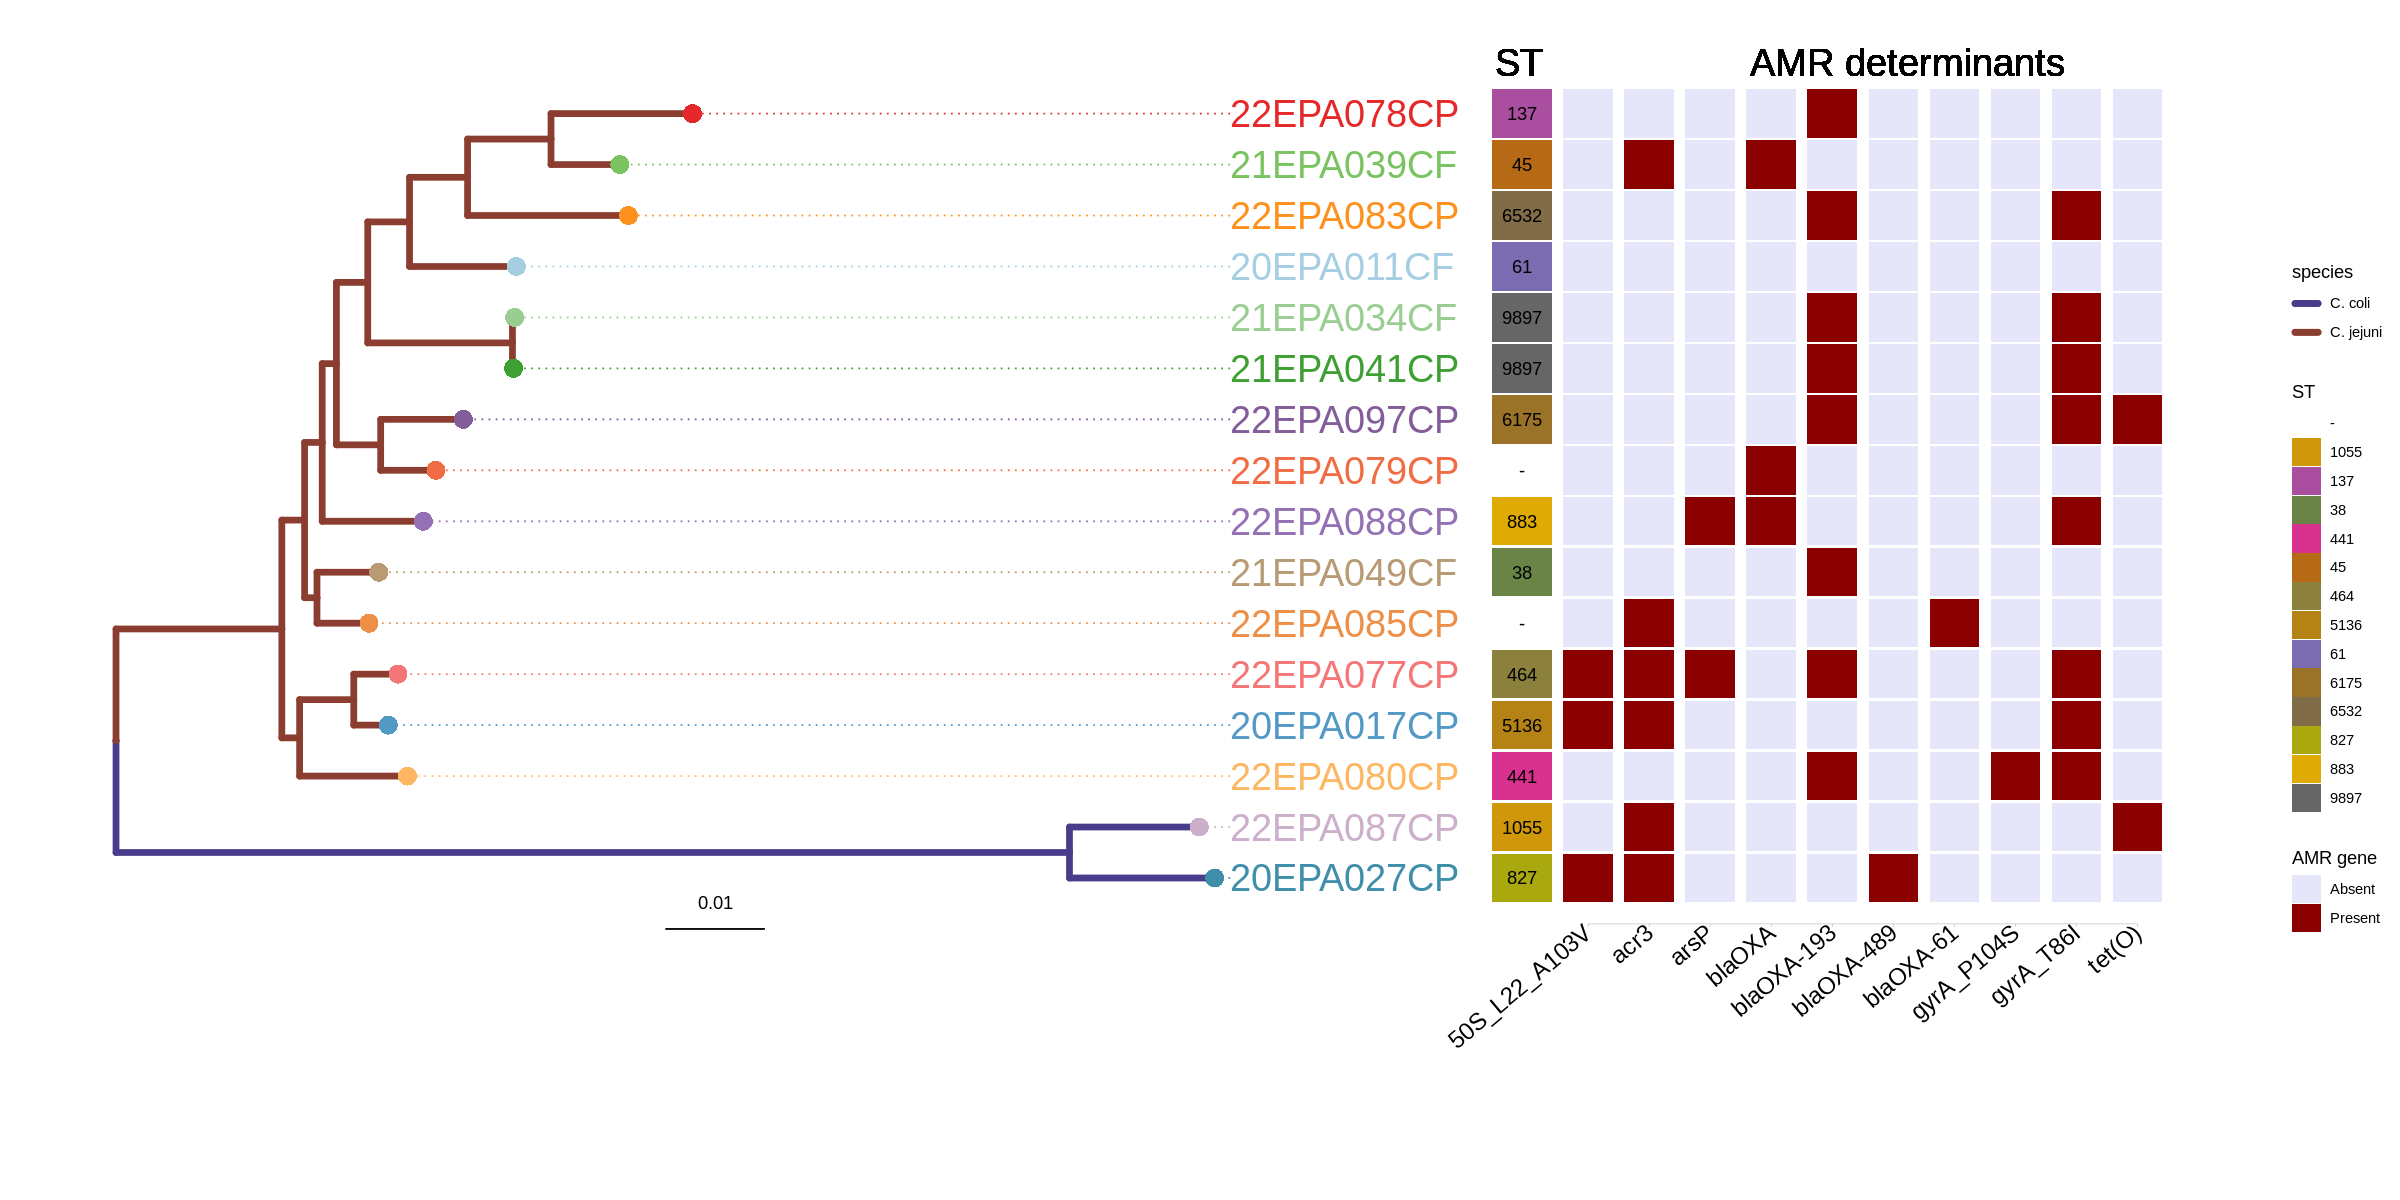

In [17]:

t1 <- read.tree ("231013.mags_only/subset_first/trimal90_all.aln.treefile")
t1 <- drop.tip (t1, mags_without_isolates)
tmag <- tree_with_ancestral_df (t1, df0=df, reroot=0.1)
write.tree (as.phylo(tmag$tre), "231206.fixlabel/240104.mags_t90.treefile")

options (repr.plot.width=20, repr.plot.height=10)
p <- ggtree (tmag$tree, aes(color=species),size=1.9) + scale_color_manual (values=c("darkslateblue", "coral4"))
p <- p + new_scale_color() + new_scale_fill()
p <- p + geom_tippoint (aes (colour=mag, fill=sample), pch=21, size=4, stroke=2)
p <- p + scale_colour_manual (values=c(alpha("white",alpha=0), "black"), guide="none") + scale_fill_manual (values=mypal, guide="none")
p <- p + new_scale("colour") + new_scale ("fill")

# select only columns fom df that match names in amr_names
df_tmp <- tmag$df %>% select (all_of(amr_names))
df_tmp$Sample_ID <- rownames(df_tmp)
df_tmp <- df_tmp[,colSums(df_tmp != "NO") > 0] # remove columns with only NO
df_tmp <- df_tmp %>% pivot_longer (cols = -Sample_ID, names_to = "amr", values_to = "yesno")

p <- p + geom_fruit(geom=geom_tile, mapping=aes(y=Sample_ID, fill=ST), offset=0.28, width=0.006, height=0.95,)
p <- p + geom_fruit(geom=geom_text, mapping=aes(y=Sample_ID, label=ST), offset=0.)
p <- p + ggplot2::scale_fill_manual(values = getPal_ST, na.value="white", name="ST")
p <- p + new_scale("colour") + new_scale ("fill")

p <- p + geom_fruit(
        geom=geom_tile, data=df_tmp, mapping=aes(y=Sample_ID, x=amr, fill=yesno), 
        pwidth=0.5, offset=0.03, width=0.005, height = 0.95, # widht height are for each square
        axis.params=list(axis= "x", text.size  = 5, text.angle=40, hjust = 1, vjust= 0.5)
        )
p <- p + ggplot2::scale_fill_manual(values = c("YES"="darkred","NO"="lavender"), 
        labels=c("YES"="Present", "NO"="Absent"),na.value="lavender", name="AMR gene") # one AMG is all-negative so we need na.value
p <- p + new_scale("colour") + new_scale ("fill")

p <- p + geom_tiplab (size=8, aes(colour=sample), align=T, offset=0.001) + scale_colour_manual (values=mypal, guide="none")
p <- p + ylim (-4, 17) + geom_treescale() # + xlim(NA,0.1) 

p <- p + geom_text(aes(x=0.141, y=17, label="ST"), size=8, hjust=0.5)
p <- p + geom_text(aes(x=0.18, y=17, label="AMR determinants"), size=8, hjust=0.5)

p
ggsave ("231206.fixlabel/240104.mags_t90.pdf", p, width=20, height=10)
ggsave ("231206.fixlabel/240104.mags_t90.png", p, width=20, height=10)
